In [59]:
# import builtins
# original_print = print
# def custom_print(*args, **kwargs):
#     new_args = []
#     for arg in args:
#         if isinstance(arg, float):
#             new_args.append(f'{arg:.10f}')
#         else:
#             new_args.append(arg)
#     original_print(*new_args, **kwargs)
# builtins.print = custom_print

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import seaborn as sns
from scipy.stats import gaussian_kde
from datetime import datetime, timedelta


In [61]:


# Define the variable name for the unit power efficiency column
unit_power_efficiency = 'TH/J'

# Load the data for the maximum efficiency for all dates
max_efficiency_table = pd.read_csv('../../hardwarelist/Bitcoin max updated2.csv')

# Assuming the 'Date' column in max_efficiency_table is in a format that can be converted to datetime
max_efficiency_table['date'] = pd.to_datetime(max_efficiency_table['date'])

data = pd.read_csv('../5_processing_extracted_data/plotdata.csv') # date,row_index,hardware_name,TH/J,max_efficiency,year

# Convert the 'date' column to a datetime format
data['date'] = pd.to_datetime(data['date'])

# keep only data from 2011 onwards
data = data[data['date'] >= '2011-01-05']



In [62]:
# econometrics

# Step 1: Average the data points on a quarterly basis
# Ensure that 'TH/J' is a numeric type
data['TH/J'] = pd.to_numeric(data['TH/J'], errors='coerce')

# Create a 'quarter' column by offsetting the 'date' by 15 days and then using to_period
# data['quarter'] = (data['date'] - timedelta(days=45)).dt.to_period('Q')
data['quarter'] = (data['date'] - timedelta(days=0)).dt.to_period('Q')

# Group by 'quarter' and calculate the mean of 'TH/J'
quarterly_data = data.groupby('quarter')['TH/J'].mean().reset_index()

# Convert 'quarter' back to datetime (first day of the quarter)
quarterly_data['quarter'] = quarterly_data['quarter'].dt.to_timestamp()

# obtain monthly data
data['month'] = data['date'].dt.to_period('M')
monthly_data = data.groupby('month')['TH/J'].mean().reset_index()
monthly_data['month'] = monthly_data['month'].dt.to_timestamp()

# Step 2: Create a time series for power efficiency
# Create the time variable t (in quarters)
quarterly_data['t'] = np.arange(len(quarterly_data))+1

# Then, create t^2
quarterly_data['t_squared'] = quarterly_data['t'] ** 2

# Get the maximum power efficiency over time
def get_max_efficiency(date):
    date = str(date)[:10]
    try:
        return max_efficiency_table[max_efficiency_table['date'] == date]['max (TH/J)'].values[0]
    except:
        return -1
quarterly_data['P_max_t'] = quarterly_data['quarter'].apply(lambda x: get_max_efficiency(x))

# Create the log of P_max_t
quarterly_data['log_P_max_t'] = np.log(quarterly_data['P_max_t'])

# Convert 't' to float to avoid issues with negative powers
quarterly_data['t'] = quarterly_data['t'].astype(float)

# Define the range of lags to test for the AR and MA components
p_range = range(1, 2)  # AR component
q_range = range(1, 2)  # MA component

best_aic = np.inf
best_bic = np.inf
best_order = None
best_model_fit = None

# Loop over the range of p and q values
for p in p_range:
    for q in q_range:
        try:
            # Fit the ARIMA model with the current p and q values
            model = ARIMA(quarterly_data['TH/J'], order=(p, 1, q))
            model_fit = model.fit()
            
            # Check if the current model has a lower AIC or BIC than the best one found so far
            if model_fit.aic < best_aic or model_fit.bic < best_bic:
                best_aic = model_fit.aic
                best_bic = model_fit.bic
                best_order = (p, 1, q)
                best_model_fit = model_fit
        except Exception as e:
            print(f"ARIMA({p},0,{q}) - Model failed to fit: {e}")

# Print the best model's AIC, BIC, and order
print(f"Best ARIMA model order: {best_order}")
print(f"Best ARIMA model AIC: {best_aic}")
print(f"Best ARIMA model BIC: {best_bic}")



Best ARIMA model order: (1, 1, 1)
Best ARIMA model AIC: -530.7540404306031
Best ARIMA model BIC: -524.9585635324302


In [63]:
# Extract the parameter values from the best model fit
params = best_model_fit.params
param_str = ', '.join([f'{key}={value:.3f}' for key, value in params.items()])

dpi = 110


# unit = "TH/J"
unit = "H/J"
# func = "ln"
func = "log10"
def process(x,apply_multiplier=False):
    multi = 1000000000000 if unit == "H/J" else 1
    if apply_multiplier == False:
        multi = 1
    if func == "ln":
        return np.log(x*multi)
    if func == "log10":
        return np.log10(x*multi)

In [64]:
process(data[unit_power_efficiency])

8       -5.697821
9       -5.762859
10      -5.697821
11      -5.719877
12      -5.757061
           ...   
14524   -1.622994
14525   -1.534160
14526   -1.470491
14527   -1.332438
14528   -1.557641
Name: TH/J, Length: 14521, dtype: float64

In [65]:
gray_scatter_x = data['date'] # looks like 2011-02-19 09:38:19
gray_scatter_y = process(data[unit_power_efficiency],apply_multiplier=True) # looks like 6.302179

red_scatter_x = quarterly_data['quarter'] # looks like 2011-01-01
red_scatter_y = process(quarterly_data['TH/J'],apply_multiplier=True) # looks like 6.217607 (average of that time period)

lime_scatter_x = monthly_data['month'] # looks like 2011-01-01
lime_scatter_y = process(monthly_data['TH/J'],apply_multiplier=True) # looks like 6.217607 (average of that time period)

max_plot_x = max_efficiency_table['date']
max_plot_y = process(max_efficiency_table['max (TH/J)'],apply_multiplier=True)

In [66]:
monthly_price_joules = pd.read_csv('./monthly_price_joules.csv')
price_plot_x = pd.to_datetime(monthly_price_joules['date'])
price_plot_y = process(monthly_price_joules['price'])

joules_plot_x = pd.to_datetime(monthly_price_joules['date'])
joules_plot_y = process(monthly_price_joules['real_joules_per_coin'])

price_offset = 0
price_plot_y = price_plot_y + price_offset

joules_offset = 0
joules_plot_y = joules_plot_y + joules_offset

time_to_double = 2.6
# koomey's law: after 2018, the efficiency doubles every 2.6 years
first_2018_efficiency = quarterly_data[quarterly_data['quarter'] == '2018-01-01']['TH/J'].values[0]
koomey_preds_efficiency = []
for i in range(4*(2024-2018)+1):
    koomey_preds_efficiency.append(first_2018_efficiency * 2**((i/4)/time_to_double))
koomey_preds_efficiency = np.array(koomey_preds_efficiency)
koomey_preds_efficiency = process(koomey_preds_efficiency,apply_multiplier=True)
koomey_preds_x = pd.date_range(start='2018-01-01', periods=len(koomey_preds_efficiency), freq='Q')

# koomey's law for joules:
first_2018_joules = monthly_price_joules[monthly_price_joules['date'] == '2017-12-31']['real_joules_per_coin'].values[0]
koomey_preds_joules = []
for i in range(12*(2024-2018)+1):
    koomey_preds_joules.append(first_2018_joules * 2**((i/12)/time_to_double))
koomey_preds_joules = np.array(koomey_preds_joules)
koomey_preds_joules = process(koomey_preds_joules)
koomey_preds_joules_x = pd.date_range(start='2018-01-01', periods=len(koomey_preds_joules), freq='M')

# koomey's law for price:
first_2018_price = monthly_price_joules[monthly_price_joules['date'] == '2017-12-31']['price'].values[0]
koomey_preds_price = []
for i in range(12*(2024-2018)+1):
    koomey_preds_price.append(first_2018_price * 2**((i/12)/time_to_double))
koomey_preds_price = np.array(koomey_preds_price)
koomey_preds_price = process(koomey_preds_price)
koomey_preds_price_x = pd.date_range(start='2018-01-01', periods=len(koomey_preds_price), freq='M')


In [67]:
yearly_counts = gray_scatter_x.dt.year.value_counts().sort_index()
print(yearly_counts.mean(),yearly_counts.std())
# export to latex
print(yearly_counts.to_frame().T.to_latex())

1117.0 687.4218743488843
\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
date & 2011 & 2012 & 2013 & 2014 & 2015 & 2016 & 2017 & 2018 & 2019 & 2020 & 2021 & 2022 & 2023 \\
\midrule
count & 1146 & 803 & 2001 & 2379 & 1899 & 1320 & 1569 & 1160 & 575 & 363 & 644 & 422 & 240 \\
\bottomrule
\end{tabular}



In [68]:
# plt.rcParams["text.usetex"] =  True

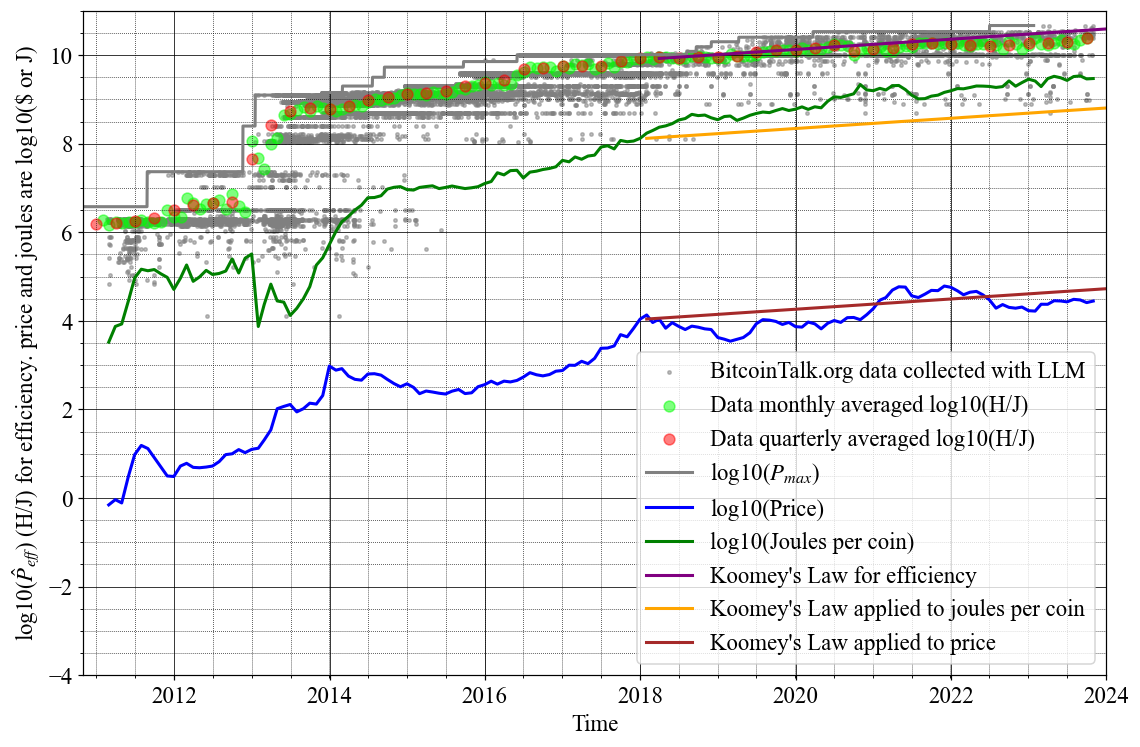

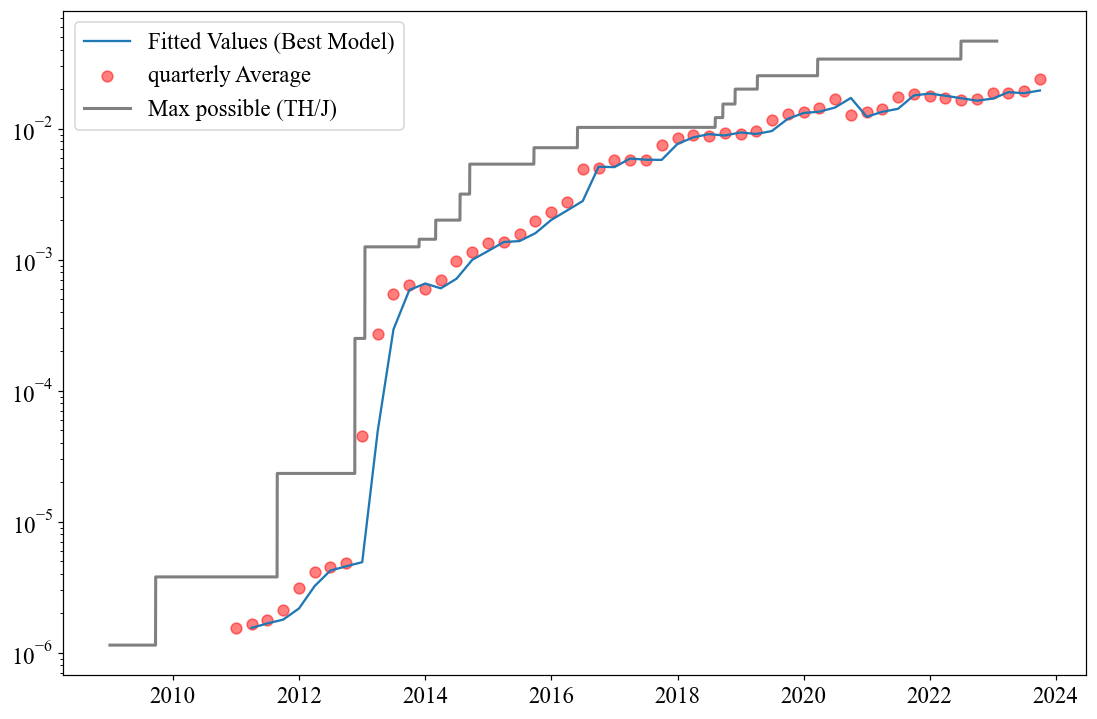

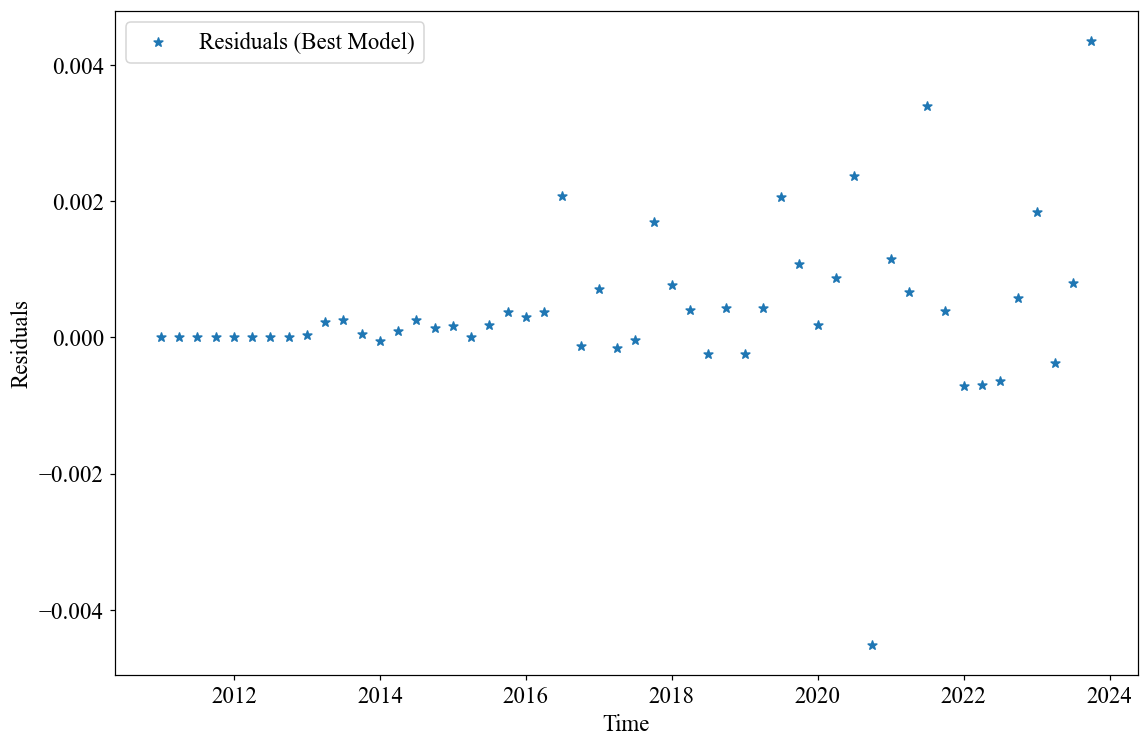

In [69]:

plt.rcParams['font.family'] = 'Times New Roman'

plt.rcParams.update({'font.size': 15})

koomey_extra = " starting 2018"
koomey_extra = ""

# Step 4: Plot single point for each quarter + all the data points using the best model
plt.figure(figsize=(12, 8), dpi=dpi)
plt.scatter(gray_scatter_x, gray_scatter_y, c='gray', s=5, label='BitcoinTalk.org data collected with LLM', alpha=0.5)
plt.scatter(lime_scatter_x, lime_scatter_y, c='lime', s=50, label=f'Data monthly averaged {func}({unit})', alpha=0.5)
plt.scatter(red_scatter_x, red_scatter_y, c='red', s=50, label=f'Data quarterly averaged {func}({unit})', alpha=0.5)
plt.plot(max_plot_x, max_plot_y, color='gray', label=func+'($P_{max}$)', linewidth=2)
plt.plot(price_plot_x, price_plot_y, color='blue', label=func+'(Price)'+("" if price_offset == 0 else str(price_offset)), linewidth=2)
plt.plot(joules_plot_x, joules_plot_y, color='green', label=func+'(Joules per coin)'+("" if joules_offset == 0 else str(joules_offset)), linewidth=2)
plt.plot(koomey_preds_x, koomey_preds_efficiency, color='purple', label='Koomey\'s Law for efficiency' + koomey_extra, linewidth=2)
plt.plot(koomey_preds_joules_x, koomey_preds_joules, color='orange', label='Koomey\'s Law applied to joules per coin' + koomey_extra, linewidth=2)
plt.plot(koomey_preds_price_x, koomey_preds_price, color='brown', label='Koomey\'s Law applied to price' + koomey_extra, linewidth=2)
# plt.plot(quarterly_data['quarter'][1:], np.log(best_model_fit.fittedvalues[1:]), label='Model: ln($\hat{P}_{eff}$)', linestyle='--')
plt.xlabel('Time')
plt.ylabel(func+'($\hat{P}_{eff}$) (' + unit + ') for efficiency. price and joules are ' + func + '(\$ or J)')
plt.yscale('linear')
# put legend in bottom right
plt.legend(loc='lower right')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.minorticks_on()
# Start the x axis at 2011
plt.xlim(pd.Timestamp('2010-11-01'), pd.Timestamp('2024-01-01'))
# Start the y axis at -1
plt.ylim(-4, 11)

# Update the box with model details
ar_params = ', '.join([f'ar.L{i}={params[f"ar.L{i}"]:.1e}' for i in range(1, best_order[0]+1)])
ma_params = ', '.join([f'ma.L{i}={params[f"ma.L{i}"]:.1e}' for i in range(1, best_order[2]+1)])
sigma = params['sigma2']**0.5

textstr = '\n'.join((
    f'Formula:',
    r'ln($\hat{P}_{eff,t}$) = ar.L1 * ln($\hat{P}_{eff,t-1}$) + ar.L2 * ln($\hat{P}_{eff,t-2}$) + ma.L1 * $ε_{t-1}$ + $ε_t$',
    f'AR, order p={best_order[0]}, with {ar_params}',
    f'MA, order q={best_order[2]}, with {ma_params}',
    f'Error term variance, σ={sigma:.1e}',
    f'Error term Ljung-Box test, p = 8.5e-01',
    f'Model estimated through minimizing AIC and BIC',
    f'Stationarity of first derivative tested with ADF, p = 9.9e-26',
    f'Samples count: {len(data)}',
))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# Adjust the position of the box to be next to the plot
# plt.gca().text(0.45, 0.26, textstr, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=props)
plt.savefig('pdfs/data_plot.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Step 5: Plot P_eff,t(t) + Single point for each quarter, excluding the first quarter from the fitted line using the best model
plt.figure(figsize=(12, 8), dpi=dpi)
# Exclude the first quarter from the fitted values line
plt.plot(quarterly_data['quarter'][1:], best_model_fit.fittedvalues[1:], label='Fitted Values (Best Model)')
plt.scatter(quarterly_data['quarter'], quarterly_data['TH/J'], c='red', s=50, label='quarterly Average', alpha=0.5)
plt.plot(max_efficiency_table['date'], max_efficiency_table['max (TH/J)'], color='gray', label='Max possible (TH/J)', linewidth=2)
plt.yscale('log')
plt.legend()
plt.show()

# Step 6: Plot with just the residual term using the best model, without connecting lines
plt.figure(figsize=(12, 8), dpi=dpi)
plt.scatter(quarterly_data['quarter'], best_model_fit.resid, marker='*', label='Residuals (Best Model)')
plt.yscale('linear')  # Use a linear scale to better visualize the wave pattern
plt.xlabel('Time')  # Label for the x-axis
plt.ylabel('Residuals')  # Label for the y-axis
plt.legend()
plt.show()

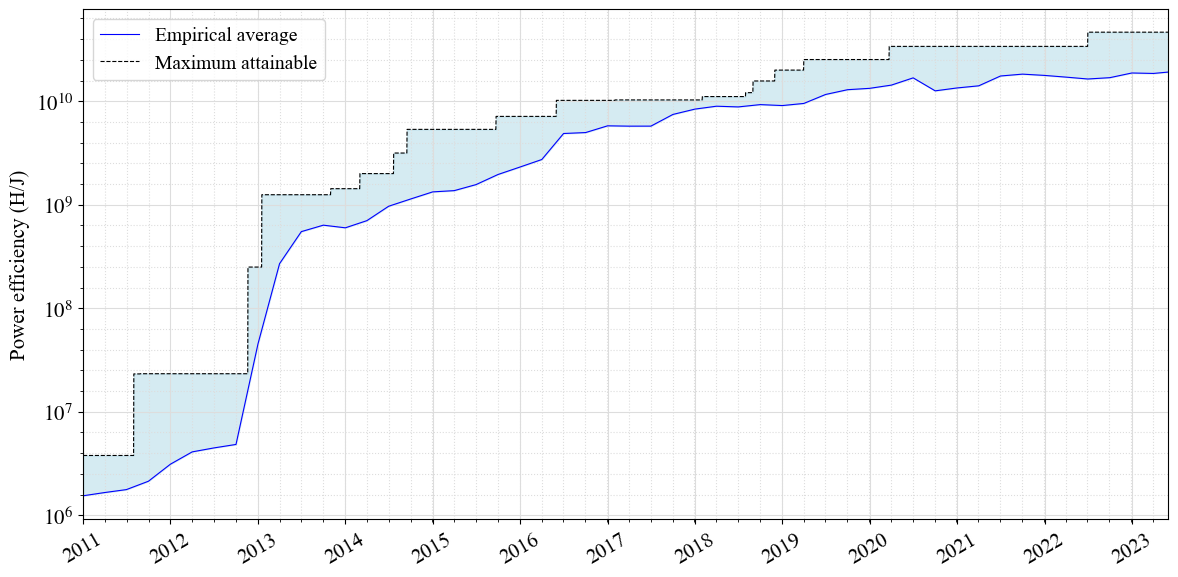

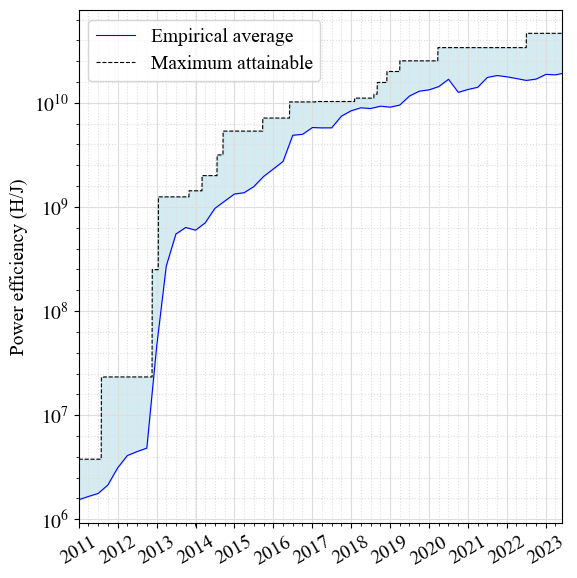

In [70]:
def plot_efficiency_comparison(ax):
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['mathtext.fontset'] = 'stix'


    # Plot efficiency and max efficiency
    ax.plot(red_scatter_x, red_scatter_y, label='Empirical average', color='blue', linewidth=0.8)
    # ax.plot(max_plot_x, max_plot_y, label='Max Efficiency', color='blue')



    pmax_alternative = pd.read_csv('../../hardwarelist/pmaxv3.csv') # date	max_efficiency
    pmax_alternative['date'] = pd.to_datetime(pmax_alternative['date'])
    pmax_alternative = pmax_alternative.set_index('date')
    ax.plot(pmax_alternative.index, process(pmax_alternative['max_efficiency']), label='Maximum attainable', color='black', linewidth=0.8, linestyle='--')




    # Fill the area, Interpolate red_scatter_y to match the length of max_plot_x
    # red_scatter_y_interp = np.interp(max_plot_x, red_scatter_x, red_scatter_y)
    # ax.fill_between(max_plot_x, max_plot_y, red_scatter_y_interp, interpolate=True, color='lightblue', alpha=0.5)

    interp2 = np.interp(pmax_alternative.index, red_scatter_x, red_scatter_y)
    ax.fill_between(pmax_alternative.index, process(pmax_alternative['max_efficiency']), interp2, interpolate=True, color='lightblue', alpha=0.5)



    # Set x-ticks to every year and format them to include "01.01."
    start = pd.Timestamp('2010-12-31 00:00:00')
    end = pd.Timestamp('2023-06-01 00:00:00')
    years = pd.date_range(start=start, end=end, freq='YS')
    ax.set_xticks(years)
    ax.set_xticklabels([f"{year.year}" for year in years], rotation=30)
    # set xlim
    ax.set_xlim(start, end)

    # Set y-axis label and format y-ticks to display as 10^x
    ax.set_ylabel('Power efficiency (H/J)', rotation='vertical')
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: "$10^{" + str(x).replace(".0","") + "}$")) #.rstrip(".0")

    # Set font to Times New Roman
    plt.rcParams['font.family'] = 'Times New Roman'

    # Make the font larger
    fs = 14
    plt.rcParams.update({'font.size': fs})

    # Increase DPI
    plt.rcParams.update({'figure.dpi': 100})

    # Rotate x-ticks
    plt.xticks(rotation=30)

    # Add a grid
    # Add more gridlines
    ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.8)
    ax.minorticks_on()

    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(colors) + 2, fancybox=True, shadow=True)
    # ax.legend(loc='upper left', bbox_to_anchor=(0, 0.9), ncol=1, fancybox=True, shadow=True)
    ax.legend()



plt.rcParams['figure.facecolor'] = 'white'
fig, ax = plt.subplots(figsize=(12, 6))
plot_efficiency_comparison(ax)
plt.savefig('pdfs/efficiencycomparison_wide.pdf', format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()
fig, ax = plt.subplots(figsize=(6, 6))
plot_efficiency_comparison(ax)
plt.savefig('pdfs/efficiencycomparison_thin.pdf', format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

In [71]:
red_scatter_y

0      6.188035
1      6.219246
2      6.247767
3      6.328509
4      6.493336
5      6.612193
6      6.650524
7      6.684027
8      7.656613
9      8.430509
10     8.740318
11     8.802722
12     8.777193
13     8.846396
14     8.985552
15     9.055736
16     9.124288
17     9.136455
18     9.194573
19     9.292325
20     9.364517
21     9.437070
22     9.688417
23     9.697507
24     9.762660
25     9.759490
26     9.759747
27     9.872659
28     9.924163
29     9.952153
30     9.945348
31     9.967638
32     9.958433
33     9.978866
34    10.065570
35    10.111706
36    10.124857
37    10.156070
38    10.226068
39    10.100638
40    10.128771
41    10.149125
42    10.244144
43    10.262062
44    10.249732
45    10.233114
46    10.215101
47    10.227987
48    10.273192
49    10.268768
50    10.288347
51    10.378035
Name: TH/J, dtype: float64

In [72]:
max_plot_y

0        6.056905
1        6.056905
2        6.056905
3        6.056905
4        6.056905
          ...    
5132    10.667453
5133    10.667453
5134    10.667453
5135    10.667453
5136    10.667453
Name: max (TH/J), Length: 5137, dtype: float64

In [73]:
price_plot_x

0     2011-02-28
1     2011-03-31
2     2011-04-30
3     2011-05-31
4     2011-06-30
         ...    
148   2023-06-30
149   2023-07-31
150   2023-08-31
151   2023-09-30
152   2023-10-31
Name: date, Length: 153, dtype: datetime64[ns]

In [74]:
quarterly_dates = red_scatter_x
data = pd.DataFrame({'Date': gray_scatter_x, 'Performance': gray_scatter_y})
quarterly_data2 = pd.DataFrame({'Date': red_scatter_x, 'Performance': red_scatter_y})

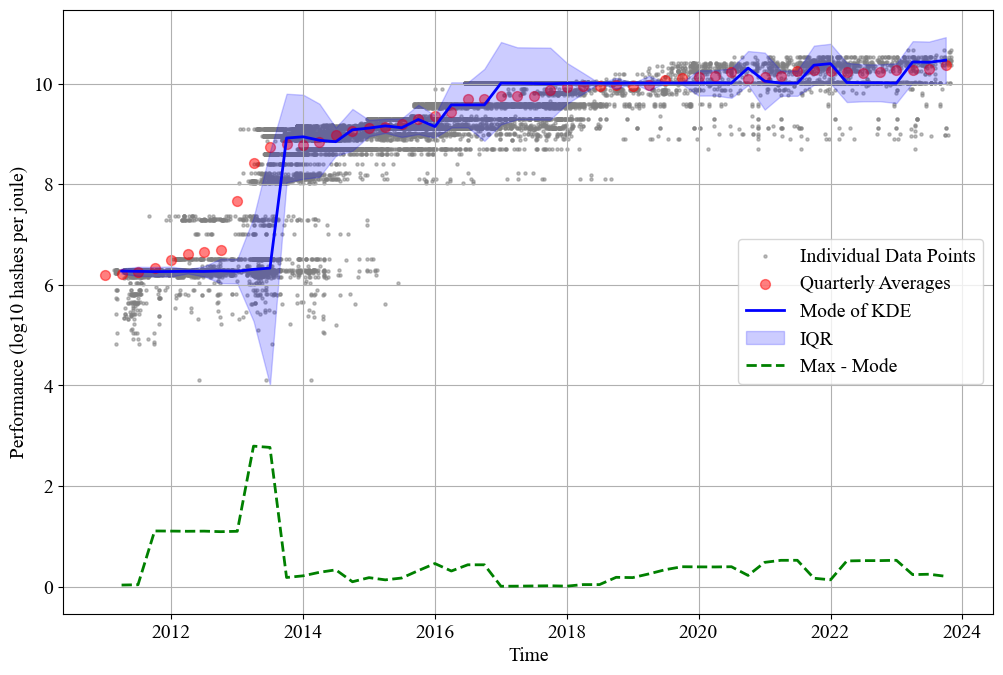

In [75]:
# Function to calculate KDE, extract mode, IQR, and max performance
def analyze_performance(data, bandwidth=0.3):
    kde = gaussian_kde(data['Performance'], bw_method=bandwidth)
    performance_range = np.linspace(data['Performance'].min(), data['Performance'].max(), 500)
    kde_values = kde(performance_range)
    mode = performance_range[np.argmax(kde_values)]
    iqr = np.subtract(*np.percentile(data['Performance'], [75, 25]))
    max_performance = data['Performance'].max()
    return mode, iqr, max_performance

# Analyzing each quarter
results = []
for date in red_scatter_x:
    quarter_start = date - pd.offsets.QuarterBegin(startingMonth=1)
    quarter_end = date
    quarter_data = data[(data['Date'] >= quarter_start) & (data['Date'] <= quarter_end)]
    if not quarter_data.empty:
        mode, iqr, max_performance = analyze_performance(quarter_data)
        results.append({'Date': date, 'Mode': mode, 'IQR': iqr, 'Max': max_performance, 'Max-Mode': max_performance - mode})

results_df = pd.DataFrame(results)

# Plotting
plt.figure(figsize=(12, 8))
plt.scatter(data['Date'], data['Performance'], c='gray', s=5, label='Individual Data Points', alpha=0.5)
plt.scatter(quarterly_data2['Date'], quarterly_data2['Performance'], c='red', s=50, label='Quarterly Averages', alpha=0.5)
plt.plot(results_df['Date'], results_df['Mode'], label='Mode of KDE', color='blue', linewidth=2)
plt.fill_between(results_df['Date'], results_df['Mode'] - results_df['IQR'], results_df['Mode'] + results_df['IQR'], color='blue', alpha=0.2, label='IQR')
plt.plot(results_df['Date'], results_df['Max-Mode'], label='Max - Mode', color='green', linestyle='--', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Performance (log10 hashes per joule)')
plt.legend()
plt.grid(True)
plt.show()

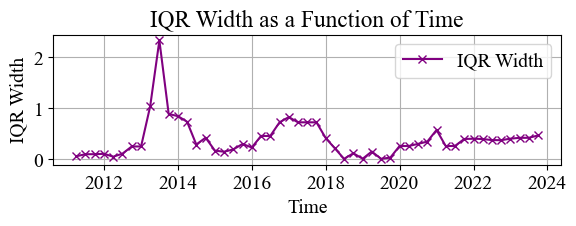

In [76]:


# Plotting the IQR width as a function of time
plt.subplot(2, 1, 2)
plt.plot(results_df['Date'], results_df['IQR'], label='IQR Width', color='purple', marker='x')
plt.xlabel('Time')
plt.ylabel('IQR Width')
plt.title('IQR Width as a Function of Time')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [77]:
# Create a DataFrame with the model's fitted values
model_values_df = pd.DataFrame({
    'quarter': quarterly_data['quarter'][1:],  # Exclude the first quarter as it doesn't have a fitted value
    'model_value': best_model_fit.fittedvalues[1:]
})
model_values_df

,quarter,model_value
1,2011-04-01,0.000002
2,2011-07-01,0.000002
3,2011-10-01,0.000002
4,2012-01-01,0.000002
5,2012-04-01,0.000003
6,2012-07-01,0.000004
7,2012-10-01,0.000005
8,2013-01-01,0.000005
9,2013-04-01,0.000049
10,2013-07-01,0.000293


In [78]:


# Merge the model_values_df with quarterly_data
# Note: Ensure that both DataFrames have the 'date' column in the same format for a successful merge
combined_data = pd.merge(quarterly_data, model_values_df, how='left', left_on='quarter', right_on='quarter')

# Drop the additional 'date' column from the merge, if needed
# combined_data.drop('quarter', axis=1, inplace=True)

# Export the combined_data DataFrame to a CSV file
# combined_data.to_csv('model_and_quarterly_data.csv', index=False) # quarter,TH/J,t,t_squared,P_max_t,log_P_max_t,model_value

In [79]:
max_eff = pd.read_csv('../../hardwarelist/Bitcoin max updated2.csv') # date,max (TH/J),useless,archaicity (TH/J)

# we need a csv with
#Date (day by day from 2009)
#ln(P_max) (TH/J)
#Data quarterly average (please put the same value for every day quarterly, instead of Na, and then it just changes quarterly)
#Model ln(P_eff)

max_eff["quarter"] = max_eff["date"].apply(lambda x: x[:7]+"-01")
max_eff["quarter"] = pd.to_datetime(max_eff["quarter"])
max_eff["ln(P_max)"] = np.log(max_eff["max (TH/J)"])
# max_eff = max_eff[["quarter","ln(P_max)"]]

combined_data["quarter"] = pd.to_datetime(combined_data["quarter"])

data2 = pd.merge(combined_data, max_eff, how='left', left_on='quarter', right_on='quarter')
data2 = data2[["date","ln(P_max)","TH/J","model_value"]]
data2 = data2.rename(columns={"date":"Date","ln(P_max)":"ln(P_max)","TH/J":"Data quarterly average","model_value":"Model ln(P_eff)"})

# forward fill the missing values
data2 = data2.fillna(method='ffill')

In [80]:
# data2.to_csv('model_and_quarterly_data_2.csv', index=False)

In [81]:
print(param_str)

ar.L1=0.461, ma.L1=-0.364, sigma2=0.000


In [82]:


# Perform the Ljung-Box test on the residuals
lb_test_result = acorr_ljungbox(best_model_fit.resid, lags=[10], return_df=True)

# Display the test results
print(lb_test_result)

     lb_stat  lb_pvalue
10  3.399922   0.970388


In [83]:


# Perform Augmented Dickey-Fuller test
adf_result = adfuller(quarterly_data['TH/J'].dropna())

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if adf_result[1] < 0.05:
    print("The time series is stationary with 95% confidence.")
else:
    print("The time series is not stationary with 95% confidence.")

ADF Statistic: 1.211356
p-value: 0.996063
Critical Values:
	1%: -3.566
	5%: -2.920
	10%: -2.598
The time series is not stationary with 95% confidence.


In [84]:


# Calculate the first derivative of the time series
quarterly_data['TH/J_diff'] = quarterly_data['TH/J'].diff()

# Drop the first row since it will be NaN after differencing
quarterly_data_diff = quarterly_data.dropna(subset=['TH/J_diff'])

# Perform the Augmented Dickey-Fuller test
adf_result = adfuller(quarterly_data_diff['TH/J_diff'])

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpret the results
if adf_result[1] < 0.05:
    print("The first derivative of the time series is stationary.")
else:
    print("The first derivative of the time series is not stationary.")

ADF Statistic: -1.861127
p-value: 0.350563
Critical Values:
	1%: -3.610
	5%: -2.939
	10%: -2.608
The first derivative of the time series is not stationary.


In [85]:
param_str

'ar.L1=0.461, ma.L1=-0.364, sigma2=0.000'